In [1]:
# Future imports
from __future__ import annotations

# Standard library imports
import csv
import os
import sys
import warnings
from typing import Set

# Third-party imports
import ast
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import tensorflow as tf
import torch
import whisper
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import re
import unicodedata

In [ ]:
# Convert MP3 files from data to WAV format
# Define paths
mp3_dir = r'C:/Users/yingx/data/MEMD_audio'
wav_dir = r'C:/Users/yingx/dat/WaveFiles'

# Create output directory if it doesn't exist
os.makedirs(wav_dir, exist_ok=True)

# Process files from 2.mp3 to 2058.mp3
for i in range(2, 2059):
    mp3_path = os.path.join(mp3_dir, f'{i}.mp3')
    wav_path = os.path.join(wav_dir, f'{i}.wav')
    
    # Only process if the MP3 file exists
    if os.path.exists(mp3_path):
        try:
            # Load MP3 file with librosa (automatically converts to 22050 Hz mono)
            y, sr = librosa.load(mp3_path, sr=None)  # sr=None keeps original sample rate
            
            # Save as WAV file using soundfile
            sf.write(wav_path, y, sr)
            
            print(f'Successfully converted {i}.mp3 to {i}.wav')
        except Exception as e:
            print(f'Error processing {i}.mp3: {str(e)}')
    else:
        print(f'{i}.mp3 not found, skipping')

print('Conversion complete!')

In [ ]:
# Create features.csv by extracting audio features from WAV files 
wav_dir = r'C:/Users/yingx/data/WaveFiles'
output_csv = r'C:/Users/yingx/data/features.csv'

def extract_features(wav_file):
    # Load the audio file
    y, sr = librosa.load(wav_file, sr=None)

    # Calculate features
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
    chroma_feature = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=y))
    harmonicity = np.mean(librosa.effects.harmonic(y))

    # Extract id from filename (e.g., 1 from 1.wav)
    base = os.path.basename(wav_file)
    id_str = os.path.splitext(base)[0]
    id_val = int(id_str)

    # Extract id from filename (e.g., 1 from 1.wav)
    base = os.path.basename(wav_file)
    id_str = os.path.splitext(base)[0]
    id_val = int(id_str)

    return {
        'id': id_val,
        'id': id_val,
        'duration': duration,
        'tempo': tempo,
        'spectral_centroid': spectral_centroid,
        'zero_crossing_rate': zero_crossing_rate,
        'chroma_feature': chroma_feature.tolist(),
        'mfccs': mfccs.tolist(),
        'rms': rms,
        'harmonicity': harmonicity
    }

def save_features_to_csv(features, csv_file):
    # Create a DataFrame from the features
    df = pd.DataFrame(features)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)

    # Save to CSV
    columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
    df = df[columns]
    columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
    df = df[columns]
    df.to_csv(csv_file, index=False)

def process_file(wav_file):
    if os.path.exists(wav_file):
        features = extract_features(wav_file)
        print(f"Processed: {wav_file}")
        return features
    else:
        print(f"File not found: {wav_file}")
        return None

def safe_extract(wav_file):
    try:
        if os.path.exists(wav_file):
            return extract_features(wav_file)
        else:
            print(f"File not found: {wav_file}")
            return None
    except Exception as e:
        print(f"Error processing {wav_file}: {e}")
        return None

if __name__ == "__main__":
    # Start from 703.wav since previous files are already processed
    wav_files = [f'{wav_dir}\\{i}.wav' for i in range(0, 2059)]
    wav_files = [f'{wav_dir}\\{i}.wav' for i in range(0, 2059)]
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    batch_size = 100
    header_written = os.path.exists(output_csv)

    for batch_start in range(0, len(wav_files), batch_size):
        batch_files = wav_files[batch_start:batch_start + batch_size]
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(safe_extract, batch_files))
        features_batch = [res for res in results if res is not None]
        if features_batch:
            df = pd.DataFrame(features_batch)
            columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
            df = df[columns]
            columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
            df = df[columns]
            df.to_csv(output_csv, mode='a', header=not header_written, index=False)
            header_written = True
        print(f"Processed batch {batch_start} to {batch_start + len(batch_files) - 1}")
        print(f"Processed batch {batch_start} to {batch_start + len(batch_files) - 1}")

    print(f"Feature extraction complete. Features saved to: {output_csv}")

In [ ]:
# Separate vocals from audio files using spectral masking and NN filter refinement
from vocal import spectral_masking_vocals

# Set your directories
input_directory = r'C:/Users/yingx/data/WaveFiles'
output_directory = r'C:/Users/yingx/data/Output'

def separatevocals(audiofilepath, outputpath):
    """Robust vocal separation with proper non-negative constraint handling"""
    # Load audio with error handling
    try:
        y, sr = librosa.load(audiofilepath, sr=None)
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None

    # First pass: spectral masking
    try:
        vocals, background = spectral_masking_vocals(y, sr)
    except Exception as e:
        print(f"Spectral masking failed: {e}")
        return None

    # Second pass: NN filter refinement with proper non-negative handling
    try:
        # Compute STFT with safe settings
        S = librosa.stft(vocals, n_fft=2048, hop_length=512)
        S_full, phase = librosa.magphase(S)
        
        # NN filter with absolute values to ensure non-negative
        S_filter = librosa.decompose.nn_filter(np.abs(S_full),
                                              aggregate=np.median,
                                              metric='cosine',
                                              width=int(librosa.time_to_frames(2, sr=sr)))
        S_filter = np.minimum(np.abs(S_full), np.abs(S_filter))

        # Ensure non-negative inputs for softmask
        X = np.abs(S_full) - np.abs(S_filter)
        X_ref = np.abs(S_filter)
        
        # Clip to ensure non-negative (add small epsilon to avoid zeros)
        X = np.clip(X, 1e-10, None)
        X_ref = np.clip(X_ref, 1e-10, None)
        
        # Apply softmask with safe parameters
        mask_v = librosa.util.softmask(X, X_ref * 10, power=1.5)
        
        # Reconstruct audio
        vocals_clean = librosa.istft(mask_v * S_full * phase)
        
        # Post-processing
        vocals_clean = librosa.util.normalize(vocals_clean)
        if len(vocals_clean) > 0:
            vocals_clean = librosa.effects.trim(vocals_clean, top_db=25)[0]
            
    except Exception as e:
        print(f"NN filter processing failed: {e}")
        return None

    # Save output
    try:
        os.makedirs(os.path.dirname(outputpath), exist_ok=True)
        sf.write(outputpath, vocals_clean, sr)
        return True
    except Exception as e:
        print(f"Error saving output: {e}")
        return False

def process_all_files(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process files with progress bar
    successful = 0
    failed = 0
    
    for i in tqdm(range(1786, 2059)):  # from 1.wav to 2058.wav
        input_path = os.path.join(input_dir, f"{i}.wav")
        output_path = os.path.join(output_dir, f"{i}.wav")
        
        # Skip if input file doesn't exist
        if not os.path.exists(input_path):
            failed += 1
            continue
            
        # Process the file
        result = separatevocals(input_path, output_path)
        
        if result:
            successful += 1
            # Append id and filename for possible CSV output
            results.append({'id': i, 'filename': f"{i}.wav", 'status': 'success'})
        else:
            failed += 1
            results.append({'id': i, 'filename': f"{i}.wav", 'status': 'failed'})
            
    print(f"\nProcessing complete! Successful: {successful}, Failed: {failed}")

# Run the processing
process_all_files(input_directory, output_directory)

In [ ]:
# Load model Whisper model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print(f"Loading Whisper model 'large' on {device} (this may take a while)...")
model = whisper.load_model("large", device=device)
print("Model loaded.")

In [ ]:
# Transcribe audio files and save to CSV
DATA_DIR = r"C:/Users/yingx/data/Output"
OUTPUT_CSV = r"C:/Users/yingx/data/transcription.csv"

def read_processed_ids(path: str) -> Set[int]:
    if not os.path.exists(path):
        return set()
    ids = set()
    try:
        with open(path, newline="", encoding="utf-8") as f:
            reader = csv.reader(f)
            header = next(reader, None)
            for row in reader:
                if not row:
                    continue
                try:
                    ids.add(int(row[0]))
                except Exception:
                    continue
    except Exception:
        return set()
    return ids

# Set parameters
START = 1
END = 2058

processed = read_processed_ids(OUTPUT_CSV)
if processed:
    print(f"Found {len(processed)} already-processed ids in {OUTPUT_CSV}; these will be skipped.")

write_header = not os.path.exists(OUTPUT_CSV)
outdir = os.path.dirname(OUTPUT_CSV)
if outdir and not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

# Allow only basic English letters, digits, spaces, and common punctuation
ALLOWED_CHARS = re.compile(r"[^a-zA-Z0-9\s.,!?;:'\"-]")

def clean_transcription_text(raw_text: str) -> str:
    # Normalize Unicode
    text = unicodedata.normalize("NFKC", raw_text or "")
    # Keep only allowed chars
    text = ALLOWED_CHARS.sub("", text)
    # Collapse extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    if write_header:
        writer.writerow(["id", "transcription"])

    for i in range(START, END + 1):
        if i in processed:
            continue
        
        filename = f"{i}_vocals.wav"
        path = os.path.join(DATA_DIR, filename)
        if not os.path.exists(path):
            continue

        try:
            # Force English and disable fp16
            result = model.transcribe(path, language="en", fp16=False)
            raw_text = result.get("text", "") or ""
            text = clean_transcription_text(raw_text)
        except Exception as e:
            print(f"Error transcribing {path}: {e}")
            text = ""

        writer.writerow([i, text])
        try:
            csvfile.flush()
            os.fsync(csvfile.fileno())
        except Exception:
            pass

        if i % 100 == 0:
            print(f"Processed up to {i}")

print(f"Done. Transcriptions written (appended) to: {OUTPUT_CSV}")

In [3]:
# Clean the transcription CSV file by replacing any rows with "Thank you." with an empty string
transcription_csv = r"C:/Users/yingx/data/transcription.csv"

# Read the CSV file
df = pd.read_csv(transcription_csv)

# Replace any text that contains "Thank you." with empty string using str.contains()
df['transcription'] = df['transcription'].apply(lambda x: '' if isinstance(x, str) and 'Thank you. Thank you.' in x else x)

# Save the cleaned data back to CSV
df.to_csv(transcription_csv, index=False)
print("Transcription file cleaned successfully!")

Transcription file cleaned successfully!


In [4]:
# Merge features.csv, transcription.csv, static_annotations_averaged_songs.csv, and emotion.csv into a singular CSV file

# Read csv
features_df = pd.read_csv(r'C:/Users/yingx/data/features.csv')
transcription_df = pd.read_csv(r'C:/Users/yingx/data/transcription.csv')
# Ensure transcription is string and cleaned one more time (just in case)
transcription_df['transcription'] = (
    transcription_df['transcription']
    .fillna('')
    .astype(str)
)
emotion_df = pd.read_csv(r'C:/Users/yingx/data/emotion.csv')

# Merge on 'id' cloumn
merged_df = features_df.merge(transcription_df, on='id', how='left').merge(emotion_df, on='id', how='right')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(r'C:/Users/yingx/data/merged_data.csv', index=False)
print("Data merged successfully into merged_data.csv")


Data merged successfully into merged_data.csv


In [5]:
# Function to create train-test splits

merged_csv_path = r"C:/Users/yingx/data/merged_data.csv"

def make_train_test_splits(merged_csv_path, feature_set="full", test_size=0.2,
    random_state=42, stratify=True, save_prefix=None):
    # 1. Read merged data
    merged_df = pd.read_csv(merged_csv_path)

    # 2. Keep only labeled rows
    labeled_df = merged_df.dropna(subset=["emotion"]).copy()

    # 3. Choose which columns to use as features
    if feature_set not in FEATURE_SETS:
        raise ValueError(
            f"Unknown feature_set '{feature_set}'. "
            f"Available options: {list(FEATURE_SETS.keys())}"
        )

    desired_cols = FEATURE_SETS[feature_set]
    missing = [c for c in desired_cols if c not in labeled_df.columns]
    if missing:
        raise ValueError(f"These requested feature columns are missing: {missing}")

    X = labeled_df[desired_cols].copy()
    y = labeled_df["emotion"].copy()

    # 4. Train-test split
    stratify_labels = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_labels,
    )

    print(f"\n=== Feature set: {feature_set} ===")
    print("Train shape:", X_train.shape, y_train.shape)
    print("Test shape :", X_test.shape, y_test.shape)
    print("Train columns:", list(X_train.columns))

    # Save to CSV
    if save_prefix is not None:
        base = f"{save_prefix}_{feature_set}"
        X_train.to_csv(f"{base}_X_train.csv", index=False)
        X_test.to_csv(f"{base}_X_test.csv", index=False)
        y_train.to_csv(f"{base}_y_train.csv", index=False)
        y_test.to_csv(f"{base}_y_test.csv", index=False)
        print(f"Saved splits using prefix: {base}*.csv")

    return X_train, X_test, y_train, y_test

FEATURE_SETS = {
    # Your current setup: everything
    "full": [
        "duration",
        "tempo",
        "spectral_centroid",
        "zero_crossing_rate",
        "chroma_feature",
        "mfccs",
        "rms",
        "harmonicity",
        "transcription",
    ]
}

# 1) Full feature set (what you have now)
X_train_full, X_test_full, y_train_full, y_test_full = make_train_test_splits(
    merged_csv_path,
    feature_set="full",
    test_size=0.2,
    random_state=42,
    stratify=True,
    save_prefix=r"C:/Users/yingx/data/"
)



=== Feature set: full ===
Train shape: (159, 9) (159,)
Test shape : (40, 9) (40,)
Train columns: ['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity', 'transcription']
Saved splits using prefix: C:/Users/yingx/data/_full*.csv


In [9]:
def create_dataset(features_dict, batch_size=32, shuffle=True):
    """
    Create a tf.data.Dataset from processed_features.

    It will automatically:
    - Combine numerical features into a (N, num_numeric, 1) tensor named 'numerical_input'
    - Use 'chroma' -> 'chroma_input' with shape (N, 12, 1) if present
    - Use 'mfcc'   -> 'mfcc_input' with shape (N, 20, 1) if present
    - Use 'text_input' as-is if present
    - Use 'labels' as targets
    """

    inputs = {}
    
    # 1) Numerical features (duration, tempo, etc.) -> numerical_input
    numeric_cols = ['duration', 'tempo', 'spectral_centroid',
                    'zero_crossing_rate', 'rms', 'harmonicity']
    available_numeric = [c for c in numeric_cols if c in features_dict]

    if available_numeric:
        # Each processed_features[feature] is shape (N,)
        numeric_arrays = [features_dict[c] for c in available_numeric]
        numeric_stack = np.stack(numeric_arrays, axis=1)  # (N, num_numeric)
        numeric_stack = np.expand_dims(numeric_stack, -1)  # (N, num_numeric, 1)
        inputs['numerical_input'] = numeric_stack

    # 2) Chroma features -> chroma_input (N, 12, 1)
    if 'chroma' in features_dict:
        chroma = features_dict['chroma']  # (N, 12)
        chroma = np.expand_dims(chroma, -1)  # (N, 12, 1)
        inputs['chroma_input'] = chroma

    # 3) MFCC features -> mfcc_input (N, 20, 1)
    if 'mfcc' in features_dict:
        mfcc = features_dict['mfcc']  # (N, 20)
        mfcc = np.expand_dims(mfcc, -1)  # (N, 20, 1)
        inputs['mfcc_input'] = mfcc

    # 4) Text / lyrics -> text_input (already (N, max_len))
    if 'text_input' in features_dict:
        inputs['text_input'] = features_dict['text_input']

    # 5) Labels
    labels = features_dict['labels']

    # Build tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((inputs, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [10]:
# Preprocessing and dataset creation for CNN-Transformer model
def safe_normalize(values, mean, std):
    """Safe normalization with epsilon protection to prevent NaN/Inf"""
    epsilon = 1e-8
    safe_std = np.maximum(std, epsilon)
    values = np.clip(values, -1e6, 1e6)
    normalized = (values - mean) / safe_std
    normalized = np.nan_to_num(normalized, nan=0.0, posinf=1e6, neginf=-1e6)
    return normalized

def preprocess_features(X, y=None, label_encoder=None,
                        tokenizer=None, max_text_len=None,
                        is_training=True, training_stats=None):
    """
    Preprocess features for CNN-Transformer model - FIXED TEST NORMALIZATION
    """
    processed_features = {}
    
    # If test data, use training statistics
    if not is_training and training_stats is not None:
        processed_features.update(training_stats)
    
    # 1. Process numerical features
    numerical_features = ['duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'rms', 'harmonicity']
    for feature in numerical_features:
        if feature in X.columns:
            values = X[feature].values.astype(np.float32)
            
            if is_training:
                # Store normalization parameters for test set
                processed_features[f'{feature}_mean'] = np.mean(values)
                processed_features[f'{feature}_std'] = np.std(values)
            
            # Use stored stats for test data
            values = safe_normalize(
                values, 
                processed_features.get(f'{feature}_mean', 0), 
                processed_features.get(f'{feature}_std', 1)
            )
            processed_features[feature] = values
    
    # 2. Process chroma features
    if 'chroma_feature' in X.columns:
        chroma_features = []
        for chroma_str in X['chroma_feature']:
            if pd.notna(chroma_str) and isinstance(chroma_str, str) and chroma_str.strip():
                try:
                    if chroma_str.startswith('[') and chroma_str.endswith(']'):
                        chroma_array = np.array(ast.literal_eval(chroma_str), dtype=np.float32)
                    else:
                        chroma_str_clean = chroma_str.replace('[', '').replace(']', '').strip()
                        if ',' in chroma_str_clean:
                            chroma_list = [float(x.strip()) for x in chroma_str_clean.split(',') if x.strip()]
                        else:
                            chroma_list = [float(x.strip()) for x in chroma_str_clean.split() if x.strip()]
                        chroma_array = np.array(chroma_list, dtype=np.float32)
                    
                    if len(chroma_array) != 12:
                        if len(chroma_array) < 12:
                            padded = np.zeros(12, dtype=np.float32)
                            padded[:len(chroma_array)] = chroma_array
                            chroma_array = padded
                        else:
                            chroma_array = chroma_array[:12]
                            
                except Exception as e:
                    chroma_array = np.zeros(12, dtype=np.float32)
            else:
                chroma_array = np.zeros(12, dtype=np.float32)
            
            chroma_features.append(chroma_array)
        
        chroma_features = np.array(chroma_features)
        
        if is_training:
            processed_features['chroma_mean'] = np.mean(chroma_features, axis=0)
            processed_features['chroma_std'] = np.std(chroma_features, axis=0)
        
        chroma_features = safe_normalize(
            chroma_features,
            processed_features.get('chroma_mean', 0),
            processed_features.get('chroma_std', 1)
        )
        processed_features['chroma'] = chroma_features
    
    # 3. Process MFCC features
    if 'mfccs' in X.columns:
        mfcc_features = []
        for mfcc_str in X['mfccs']:
            if pd.notna(mfcc_str) and isinstance(mfcc_str, str) and mfcc_str.strip():
                try:
                    if mfcc_str.startswith('[') and mfcc_str.endswith(']'):
                        mfcc_array = np.array(ast.literal_eval(mfcc_str), dtype=np.float32)
                    else:
                        mfcc_str_clean = mfcc_str.replace('[', '').replace(']', '').strip()
                        if ',' in mfcc_str_clean:
                            mfcc_list = [float(x.strip()) for x in mfcc_str_clean.split(',') if x.strip()]
                        else:
                            mfcc_list = [float(x.strip()) for x in mfcc_str_clean.split() if x.strip()]
                        mfcc_array = np.array(mfcc_list, dtype=np.float32)
                    
                    if len(mfcc_array) != 20:
                        if len(mfcc_array) < 20:
                            padded = np.zeros(20, dtype=np.float32)
                            padded[:len(mfcc_array)] = mfcc_array
                            mfcc_array = padded
                        else:
                            mfcc_array = mfcc_array[:20]
                            
                except Exception as e:
                    mfcc_array = np.zeros(20, dtype=np.float32)
            else:
                mfcc_array = np.zeros(20, dtype=np.float32)
            
            mfcc_features.append(mfcc_array)
        
        mfcc_features = np.array(mfcc_features)
        
        if is_training:
            processed_features['mfcc_mean'] = np.mean(mfcc_features, axis=0)
            processed_features['mfcc_std'] = np.std(mfcc_features, axis=0)
        
        mfcc_features = safe_normalize(
            mfcc_features,
            processed_features.get('mfcc_mean', 0),
            processed_features.get('mfcc_std', 1)
        )
        processed_features['mfcc'] = mfcc_features
    
    # 4. Process text features (unchanged)
    if 'transcription' in X.columns:
        texts = X['transcription'].fillna('').astype(str).tolist()
        if is_training:
            tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")
            tokenizer.fit_on_texts(texts)
            sequences = tokenizer.texts_to_sequences(texts)
            max_text_len = max(len(seq) for seq in sequences) or 1
            padded = pad_sequences(sequences, maxlen=max_text_len, padding='post', truncating='post')
            processed_features['text_input'] = padded.astype('int32')
            processed_features['tokenizer'] = tokenizer
            processed_features['max_text_len'] = max_text_len
        else:
            sequences = tokenizer.texts_to_sequences(texts)
            padded = pad_sequences(sequences, maxlen=max_text_len, padding='post', truncating='post')
            processed_features['text_input'] = padded.astype('int32')

    # 5. Process target labels
    if y is not None:
        if is_training:
            label_encoder = LabelEncoder()
            y_encoded = label_encoder.fit_transform(y)
            processed_features['label_encoder'] = label_encoder
        else:
            y_encoded = label_encoder.transform(y)
        processed_features['labels'] = y_encoded
        processed_features['num_classes'] = len(label_encoder.classes_)
    
    return processed_features

def prepare_cnn_transformer_data(X_train, X_test, y_train, y_test):
    """
    Complete data preparation for CNN-Transformer model - FIXED VERSION
    """
    print("Starting data preprocessing...")
    
    # Preprocess training data
    train_features = preprocess_features(X_train, y_train, is_training=True)
    
    # Extract training statistics for test data normalization
    training_stats = {}
    for key in train_features:
        if key.endswith('_mean') or key.endswith('_std'):
            training_stats[key] = train_features[key]
    
    # Preprocess test data using training statistics
    test_features = preprocess_features(
        X_test, y_test,
        label_encoder=train_features['label_encoder'],
        tokenizer=train_features.get('tokenizer'),
        max_text_len=train_features.get('max_text_len'),
        is_training=False,
        training_stats=training_stats  # Pass training stats
    )
    
    # Create TensorFlow datasets
    batch_size = 32
    train_dataset = create_dataset(train_features, batch_size=batch_size, shuffle=True)
    test_dataset = create_dataset(test_features, batch_size=batch_size, shuffle=False)
    
    # Get input dimensions
    input_dims = {}
    if 'numerical_input' in next(iter(train_dataset))[0]:
        input_dims['numerical'] = 6
    
    if 'chroma_input' in next(iter(train_dataset))[0]:
        input_dims['chroma'] = 12
    
    if 'mfcc_input' in next(iter(train_dataset))[0]:
        input_dims['mfcc'] = 20
    
    if 'text_input' in next(iter(train_dataset))[0]:
        input_dims['text'] = train_features.get('max_text_len', 197)
    
    print("Data preprocessing completed!")
    print(f"Number of classes: {train_features['num_classes']}")
    
    # Count class distribution
    labels = train_features['labels']
    class_names = train_features['label_encoder'].classes_
    counts = np.bincount(labels)

    print("\nProcessed class counts:")
    for class_name, count in zip(class_names, counts):
        print(f"{class_name}: {count}")

    # Return important preprocessing objects
    preprocessing_objects = {
        'label_encoder': train_features['label_encoder'],
        'tokenizer': train_features.get('tokenizer'),
        'max_text_len': train_features.get('max_text_len'),
        'normalization_params': training_stats
    }
    
    return train_dataset, test_dataset, input_dims, preprocessing_objects

# Updated usage
print("Preparing data (full feature set)...")
train_dataset_full, test_dataset_full, input_dims_full, preprocessing_full = prepare_cnn_transformer_data(
    X_train_full, X_test_full, y_train_full, y_test_full
)

print("\nFull Dataset Information:")
print(f"Training batches: {len(list(train_dataset_full))}")
print(f"Test batches: {len(list(test_dataset_full))}")
print(f"Input dimensions: {input_dims_full}")


# Verify batch shapes
for batch_inputs, batch_labels in train_dataset_full.take(1):
    print(f"\nBatch inputs keys: {batch_inputs.keys()}")
    for key, value in batch_inputs.items():
        print(f"{key} shape: {value.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

Preparing data (full feature set)...
Starting data preprocessing...
Data preprocessing completed!
Number of classes: 4

Processed class counts:
 Anger: 18
 Happy: 61
 Relaxed: 38
 Sad: 42

Full Dataset Information:
Training batches: 5
Test batches: 2
Input dimensions: {'numerical': 6, 'chroma': 12, 'mfcc': 20, 'text': 135}

Batch inputs keys: dict_keys(['numerical_input', 'chroma_input', 'mfcc_input', 'text_input'])
numerical_input shape: (32, 6, 1)
chroma_input shape: (32, 12, 1)
mfcc_input shape: (32, 20, 1)
text_input shape: (32, 135)
Batch labels shape: (32,)


In [11]:
# After preprocessing, check data quality
def check_data_quality(features_dict, name="Data"):
    """Check for NaN/Inf values in processed features"""
    print(f"\n=== {name} Quality Check ===")
    for key, value in features_dict.items():
        if hasattr(value, 'dtype') and np.issubdtype(value.dtype, np.number):
            nan_count = np.sum(np.isnan(value))
            inf_count = np.sum(np.isinf(value))
            if nan_count > 0 or inf_count > 0:
                print(f"⚠️  WARNING: {key} has {nan_count} NaN, {inf_count} Inf values")
            else:
                print(f"✅ {key}: shape={value.shape}, range=[{np.min(value):.4f}, {np.max(value):.4f}]")

# Run the check
print("Preparing training data...")
train_features = preprocess_features(X_train_full, y_train_full, is_training=True)
check_data_quality(train_features, "Training Data")

test_features = preprocess_features(
    X_test_full, y_test_full,
    label_encoder=train_features['label_encoder'],
    tokenizer=train_features.get('tokenizer'),
    max_text_len=train_features.get('max_text_len'),
    is_training=False
)
check_data_quality(test_features, "Test Data")

Preparing training data...

=== Training Data Quality Check ===
✅ duration_mean: shape=(), range=[45.0524, 45.0524]
✅ duration_std: shape=(), range=[0.0144, 0.0144]
✅ duration: shape=(159,), range=[-6.6486, 2.4252]
✅ tempo_mean: shape=(), range=[120.8852, 120.8852]
✅ tempo_std: shape=(), range=[34.7657, 34.7657]
✅ tempo: shape=(159,), range=[-2.2974, 3.2797]
✅ spectral_centroid_mean: shape=(), range=[1732.8534, 1732.8534]
✅ spectral_centroid_std: shape=(), range=[791.8673, 791.8673]
✅ spectral_centroid: shape=(159,), range=[-1.5662, 3.1439]
✅ zero_crossing_rate_mean: shape=(), range=[0.0407, 0.0407]
✅ zero_crossing_rate_std: shape=(), range=[0.0197, 0.0197]
✅ zero_crossing_rate: shape=(159,), range=[-1.2801, 4.6992]
✅ rms_mean: shape=(), range=[0.1347, 0.1347]
✅ rms_std: shape=(), range=[0.0866, 0.0866]
✅ rms: shape=(159,), range=[-1.4520, 3.6496]
✅ harmonicity_mean: shape=(), range=[-0.0004, -0.0004]
✅ harmonicity_std: shape=(), range=[0.0121, 0.0121]
✅ harmonicity: shape=(159,), rang

In [14]:
# Build FULL CNN-Transformer model with gradient clipping for stability

def build_cnn_transformer_model(input_dims, num_classes):
    """Build model with gradient clipping for stability"""
    
    # Inputs
    numerical_input = layers.Input(shape=(6,), name='numerical_input')
    numerical_reshaped = layers.Reshape((6, 1))(numerical_input)
    
    chroma_input = layers.Input(shape=(12, 1), name='chroma_input')
    mfcc_input = layers.Input(shape=(20, 1), name='mfcc_input')
    text_input = layers.Input(shape=(input_dims['text'],), name='text_input', dtype='int32')
    
    # Numerical features
    numerical_conv = layers.Conv1D(32, 2, activation='relu', kernel_initializer='he_normal')(numerical_reshaped)
    numerical_bn = layers.BatchNormalization()(numerical_conv)
    numerical_pool = layers.GlobalAveragePooling1D()(numerical_bn)
    
    # Chroma features
    chroma_conv = layers.Conv1D(32, 2, activation='relu', kernel_initializer='he_normal')(chroma_input)
    chroma_bn = layers.BatchNormalization()(chroma_conv)
    chroma_pool = layers.GlobalAveragePooling1D()(chroma_bn)
    
    # MFCC features
    mfcc_conv = layers.Conv1D(32, 2, activation='relu', kernel_initializer='he_normal')(mfcc_input)
    mfcc_bn = layers.BatchNormalization()(mfcc_conv)
    mfcc_pool = layers.GlobalAveragePooling1D()(mfcc_bn)
    
    # Text features - simplified for stability
    vocab_size = len(preprocessing_full['tokenizer'].word_index) + 1
    text_embedding = layers.Embedding(vocab_size, 64, mask_zero=True)(text_input)
    text_lstm = layers.LSTM(64, return_sequences=False)(text_embedding)
    text_dropout = layers.Dropout(0.5)(text_lstm)
    
    # Concatenate all features
    concatenated = layers.Concatenate()([
        numerical_pool, chroma_pool, mfcc_pool, text_dropout
    ])
    
    # Classifier
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(concatenated)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(
        inputs=[numerical_input, chroma_input, mfcc_input, text_input],
        outputs=outputs
    )
    
    return model

# Build the model
print("Building CNN-Transformer model...")
model_full = build_cnn_transformer_model(input_dims_full, num_classes=4)

# Compile the model
model_full.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, clipvalue=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model built successfully!")
model_full.summary()

# Plot model architecture (optional)
try:
    tf.keras.utils.plot_model(
        model_full, 
        to_file='cnn_transformer_model.png', 
        show_shapes=True, 
        show_layer_names=True,
        expand_nested=True
    )
    print("Model architecture saved as 'cnn_transformer_model.png'")
except:
    print("Could not plot model architecture - but model is built successfully!")

# Calculate class weights for imbalanced data (if any)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_features['labels']),
    y=train_features['labels']
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class weights: {class_weight_dict}")

# Use callbacks but with reasonable patience
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
    ]

# Train the model
print("Starting model training...")
history = model_full.fit(
    train_dataset_full,
    epochs=100,
    validation_data=test_dataset_full,
    class_weight=class_weight_dict,
    #callbacks=callbacks,
    verbose=1
)

print("Model training completed!")

Building CNN-Transformer model...
Model built successfully!
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numerical_input (InputLayer)   [(None, 6)]          0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 6, 1)         0           ['numerical_input[0][0]']        
                                                                                                  
 chroma_input (InputLayer)      [(None, 12, 1)]      0           []                               
                                                                                                  
 mfcc_input (InputLayer)        [(None, 20, 1)]      0           []                               
                                

=== Overall Metrics ===
Accuracy      : 0.3500
F1 (macro)    : 0.2669
F1 (weighted) : 0.3072

=== Classification Report ===
              precision    recall  f1-score   support

       Anger       0.17      0.25      0.20         4
       Happy       0.41      0.60      0.49        15
     Relaxed       0.00      0.00      0.00        10
         Sad       0.40      0.36      0.38        11

    accuracy                           0.35        40
   macro avg       0.24      0.30      0.27        40
weighted avg       0.28      0.35      0.31        40

=== Confusion Matrix (raw) ===
[[1 2 1 0]
 [3 9 1 2]
 [2 4 0 4]
 [0 7 0 4]]


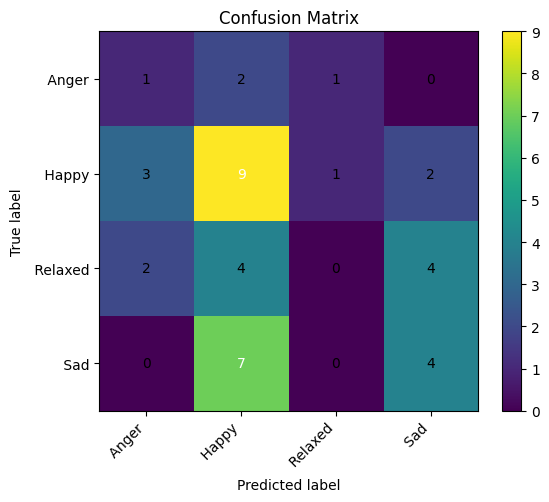

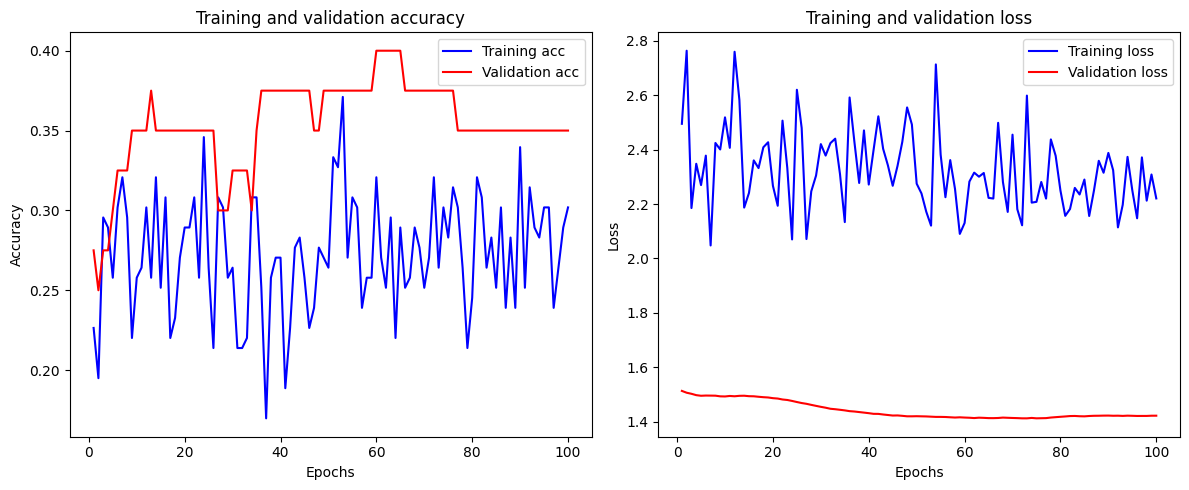

In [15]:
# FULL Model Evaluation cell: confusion matrix, F1, precision, recall, etc.

# 1. Collect true labels and predictions from the test_dataset
y_true = []
y_pred = []

for batch_inputs, batch_labels in test_dataset_full:
    # Get predicted probabilities
    probs = model_full.predict(batch_inputs, verbose=0)
    # Convert to class indices
    preds = np.argmax(probs, axis=1)

    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Basic metrics
acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("=== Overall Metrics ===")
print(f"Accuracy      : {acc:.4f}")
print(f"F1 (macro)    : {f1_macro:.4f}")
print(f"F1 (weighted) : {f1_weighted:.4f}")

# 3. Classification report (per-class precision/recall/F1)
if 'label_encoder' in train_features:
    class_names = train_features['label_encoder'].classes_
else:
    # Fallback to numeric labels if encoder not available
    class_names = [str(i) for i in np.unique(y_true)]

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("=== Confusion Matrix (raw) ===")
print(cm)

# 5. Optional: pretty plot of the confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Annotate cells
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

# Plot model loss and accuracy curves
def plot_training_history(history):
    """Plot training & validation accuracy and loss"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history)

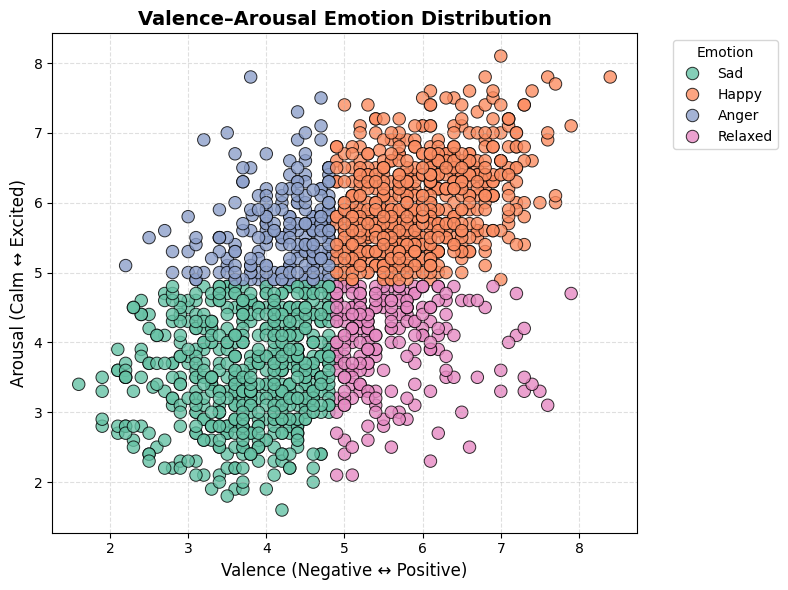

In [21]:
# Use the static annotations dataframe `df` which already contains valence_mean, arousal_mean and emotion.
# Rename song_id -> id for consistency if needed.
df = pd.read_csv("C:/Users/yingx/OneDrive/Documents/GitHub/Capstone/data/static_annotations_averaged_songs_1_2000.csv")

# Define a function to determine emotion
def get_emotion(row):
    val = row["valence_mean"]
    aro = row["arousal_mean"]

    if val < 4.9 and aro < 4.9:
        return "Sad"
    elif val < 4.9 and aro >= 4.9:
        return "Anger"
    elif val >= 4.9 and aro < 4.9:
        return "Relaxed"
    elif val >= 4.9 and aro >= 4.9:
        return "Happy"
    else:
        print("Error in determining emotion for row:", row)
        return "Unknown"

# Apply the function to each row
df["emotion"] = df.apply(get_emotion, axis=1)
plot_df = df[['song_id', 'valence_mean', 'arousal_mean', 'emotion']].rename(columns={'song_id': 'id'})

# Clean any label whitespace
plot_df['emotion'] = plot_df['emotion'].astype(str).str.strip()

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x='valence_mean',
    y='arousal_mean',
    hue='emotion',
    palette='Set2',
    s=80,
    edgecolor='k',
    alpha=0.8
)

plt.title('Valence–Arousal Emotion Distribution', fontsize=14, weight='bold')
plt.xlabel('Valence (Negative ↔ Positive)', fontsize=12)
plt.ylabel('Arousal (Calm ↔ Excited)', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()